In [213]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from sklearn.linear_model import LinearRegression
import string
from Bio import Cluster
from sklearn.decomposition import PCA as sklPCA
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans
from collections import Counter

# Import all usefull functions

In [274]:
def MinMaxScaler(df):
    newDf = df.copy()
    newDf -= newDf.min()
    newDf /= newDf.max()
    return newDf

def StandardScaler(df):
    newDf = df.copy()
    newDf = (newDf-newDf.mean())/newDf.std()
    return newDf

# linear regression based discretisation
def RegDiscretisation(df,segmentSize):
    newDf = pd.DataFrame(columns=df.columns)
    nbSegments = math.ceil(len(df)/segmentSize)
    segments = np.array_split(df,nbSegments)
    for i in range(len(segments)):
        regression_model = LinearRegression()
        for c in segments[i].columns :
            regression_model.fit(segments[i]['time'].values.reshape(-1,1),segments[i][c].values)
            newDf.loc[i,c] = float(regression_model.coef_)
    return newDf

def convertLR2(x,thresholdList):
    letters =[i for i in string.ascii_uppercase]
    n = len(thresholdList) - 1
    letters = letters[0:n]
    for i in range(n):
        if x>thresholdList[i] and x<thresholdList[i+1]:
            return letters[n-i-1]
        
def LRtransform2(df,thresholdList):
    return df.applymap(lambda x : convertLR2(x,thresholdList))

def splitEngineTorqueIncrease2(chaine) :
    if ('C' in chaine) or ('D' in chaine) or ('E' in chaine) :
        if 'A' == chaine[-1] or 'B' == chaine[-1]:
            return True
        else :
            return False
    else :
        return False

def splitHoops(df,referenceKey,splitFunction):
    listdf = []
    curseur = 0
    listValeurAct = []
    for value in df[referenceKey]:
        listValeurAct.append(value)
        if splitFunction(listValeurAct):
            # split
            listdf.append(df[curseur:curseur + len(listValeurAct) - 1])
            curseur = curseur + len(listValeurAct) - 1
            listValeurAct = [value]
    listdf.append(df[curseur:df.shape[0]])
    return listdf

def getValuesHoops(listHoops,df,segmentSize):
    hoopsValues = []
    for hoop in listHoops:
        index = [i for i in hoop.index]
        start = index[0]*segmentSize
        end = index[-1]*segmentSize
        hoopsValues.append(df.loc[start:end])
    return hoopsValues

def countHoop(listHoops, height):
    letters = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q']
    df = pd.DataFrame(columns=pd.MultiIndex.from_product([listHoops[0].columns,letters[:2**height+1]]))
    for i in range(len(listHoops)):
        hoop = listHoops[i]
        for column in hoop.columns:
            dicLetter = dict((key, 0) for key in letters[:2**height+1])
            for letter in hoop[column]:
                dicLetter[letter] += 1
            for key in dicLetter.keys():
                df.loc[i, (column, key)] = dicLetter[key]
    return df

def getFeatures(listHoops,listValuesHoops):
    featuresMatrix = []
    for i in range(len(listHoops)):
        '''# nb of appearance of symbols for torque LR
        features = nb.loc[i,'ActMod_trqClth'].tolist()
        nbLetters = sum(features)
        # nb of appearance of symbols for engine speed
        features = features + nb.loc[i,'Epm_nEng'].tolist()
        # nb of appearance of symbols for pedal position
        features = features + nb.loc[i,'APP_r'].tolist()'''
        # max - starting value
        amplitude = listValuesHoops[i]['ActMod_trqClth'].max()-listValuesHoops[i].loc[listValuesHoops[i].index[0],'ActMod_trqClth']
        # max torque value
        maxTrq = listValuesHoops[i]['ActMod_trqClth'].max()
        # duration of acceleration
        duration = listValuesHoops[i].loc[listValuesHoops[i]['ActMod_trqClth'].idxmax(),'time']-listValuesHoops[i].loc[listValuesHoops[i].index[0],'time']
        # last value of torque
        lastValueTrq = listValuesHoops[i].loc[listValuesHoops[i].index[-1],'ActMod_trqClth']
        # first value of engine speed
        firstValueEng = listValuesHoops[i].loc[listValuesHoops[i].index[0],'Epm_nEng']
        # last value of engine speed
        lastValueEng = listValuesHoops[i].loc[listValuesHoops[i].index[-1],'Epm_nEng']
        # firstValue of torque
        firstValueTrq = listValuesHoops[i].loc[listValuesHoops[i].index[0],'ActMod_trqClth']
        # gear nb
        gear = int(listValuesHoops[i]['Tra_numGear'].value_counts().index[0])
        featuresMatrix.append([gear,i,firstValueTrq,lastValueTrq,maxTrq,duration,amplitude,firstValueEng,lastValueEng])
    return featuresMatrix

def getFeaturesCluster(featuresMatrixDf,gearMode):
    return featuresMatrixDf.loc[featuresMatrixDf.iloc[:,0] == gearMode]

def getHoopCluster(hoops, hoopsValues, gearLabel, gearMode):
    clusterSR = []
    clusterValues = []
    for i in range(len(hoops)):
        if gearLabel[i] == gearMode:
            clusterSR.append(hoops[i])
            clusterValues.append(hoopsValues[i])
    return clusterSR, clusterValues

def sumDist(array):
    return np.sum(np.linalg.norm(array-np.mean(array,axis=0),axis=1))

# Get frequency of every possible association
def frequencyAssociation(symbolicRepresentation,windowSize):
    symbolicRepresentationTransformed = [''.join(symbolicRepresentation[i:i+windowSize]) for i in range(len(symbolicRepresentation)-windowSize+1)]
    return Counter(symbolicRepresentationTransformed)

# Transforming a list of letters into a simplified form : letter and occurences
def transformLetters(letters):
    l1 = []
    l2 = []
    currentLetter = letters[0]
    occurences = 1
    l1.append(currentLetter)
    for l in letters[1:]:
        if l == currentLetter:
            occurences += 1
        else:
            currentLetter = l
            l1.append(currentLetter)
            l2.append(occurences)
            occurences = 1
    l2.append(occurences)
    return l1, l2

#Return a dataframe of probability
#Input : dataframe, dfs
#       Integer, nbletterKonowed
#output a dataframe
def probahoops(dfs,nbletterKnowed,nbletterGuessed):
    index = np.unique(dfs.values)
    indexbis = index.copy()
    nblines = dfs.shape[0]
    #We create the new index of our table of proba
    for i in range(0,nbletterKnowed + nbletterGuessed -1) :
        newIndex = []
        for i in range(len(index)):
            for j in range(len(indexbis)):
                newIndex.append(index[i]+indexbis[j])
        index = newIndex.copy()
    dfp = pd.DataFrame(index=index,columns=dfs.columns)
    #Now we compute probabilities for each columns
    for c in dfs.columns :
        valeurs = dfs[c].values
        countA = frequencyAssociation(valeurs,nbletterKnowed)
        count = frequencyAssociation(valeurs,nbletterKnowed + nbletterGuessed)
        for asso in count :
            dfp[c][asso] = count[asso]/(countA[asso[0:nbletterKnowed]])
    index2 = {}
    for ind in index :
        index2[ind]=ind[0:nbletterKnowed]+' -> '+ ind[nbletterKnowed:nbletterKnowed+nbletterGuessed]
    dfp = dfp.rename(index=index2)
    dfp = dfp.replace(np.NaN,0)
    return dfp

# Main loop

In [190]:
# The goal is to go through all the files from one cycle and create one big feature matrix (one line being one hoop)
fileNames1 = ['01_drivingCycle00.dat.csv','02_drivingCycle00.dat.csv','03_drivingCycle00.dat.csv','04_drivingCycle00.dat.csv','05_drivingCycle00.dat.csv','06_drivingCycle00.dat.csv','07_drivingCycle00.dat.csv','09_drivingCycle00.dat.csv','10_drivingCycle00.dat.csv','11_drivingCycle00.dat.csv','12_drivingCycle00.dat.csv']

featuresMatrix = []
allHoopsValues = []
allHoops = []
thresholds = [-np.inf,-250,-30,30,250,np.inf]

# creation of the features matrix
for file in fileNames1:
    path = r"C:\\Users\\noah-\\Desktop\\ECU\\ECU10HZ\\csvCycle0\\" + file
    df = pd.read_csv(path,index_col=[0])
    df = df.fillna(method='bfill')
    dfStd = StandardScaler(df[['time','Epm_nEng','APP_r','ActMod_trqClth']]).fillna(method='backfill')
    LR = LRtransform2(RegDiscretisation(dfStd,10),thresholds)
    listHoops = splitHoops(LR,'ActMod_trqClth',splitEngineTorqueIncrease2)
    listValuesHoops = getValuesHoops(listHoops,df,10)
    allHoops = allHoops + listHoops
    allHoopsValues = allHoopsValues + listValuesHoops
    featuresMatrix = featuresMatrix + getFeatures(listHoops,listValuesHoops)

outputs = []
hoopsSR = []
hoopsValues = []

# splitting the features and the hoops by gear to then apply an other clusterisation
for i in range(0,7):
    featuresDf = pd.DataFrame.from_records(featuresMatrix)
    featuresDf[1] = featuresDf.index
    outputs.append(getFeaturesCluster(featuresDf,i).values)
    gearLabel = featuresDf.values[:,0]
    SR, values = getHoopCluster(allHoops, allHoopsValues, gearLabel,i)
    hoopsSR.append(SR)
    hoopsValues.append(values)

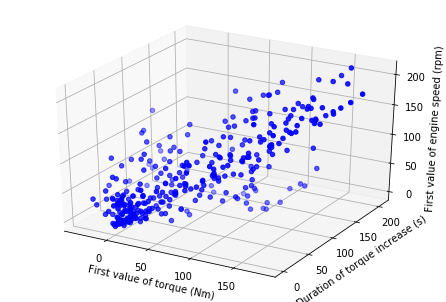

In [334]:
#output = pd.DataFrame.from_records(featuresMatrix).values

#labels = output[:,0]
#LABEL_COLOR_MAP = {0 : 'r', 1 : 'b', 2 : 'k', 3 : 'y', 4 : 'c', 5 : 'g', 6 : 'm'}
#label_color = [LABEL_COLOR_MAP[l] for l in labels]

output = outputs[1]
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(output[:,3], output[:,4], output[:,6], c='b', marker='o')
ax.set_xlabel('First value of torque (Nm)')
ax.set_ylabel('Duration of torque increase (s)')
ax.set_zlabel('First value of engine speed (rpm)')
plt.show()

#fig = plt.figure()
#plt.scatter(output[:,0], output[:,2])
#plt.show()

# Feature selection

In [ ]:
# 1D
gear = 6

for i in range(2,len(featuresMatrix[0])):
    plt.scatter(outputs[gear][:,i],np.zeros(len(outputs[gear])))
    plt.show()

In [ ]:
# 2D
for i in range(2,len(featuresMatrix[0])):
    plt.scatter(outputs[gear][:,3],outputs[gear][:,i])
    plt.show()

In [ ]:
# 3D
for i in range(2,len(featuresMatrix[0])):
    fig = plt.figure()
    ax = Axes3D(fig)
    ax.scatter(outputs[gear][:,3], outputs[gear][:,7], outputs[gear][:,i], c='b', marker='o')
    plt.show()

In [10]:
featuresM = []
featuresM.append([1,4,6])
featuresM.append([3,4,6])
featuresM.append([1,6,7])
featuresM.append([3,6,7])
featuresM.append([3,6,7])
featuresM.append([3,6,7])
featuresM.append([3,7,4])

featuresA = []
featuresA.append([1,4,6])
featuresA.append([3,5,7])
featuresA.append([1,3,6])
featuresA.append([3,5,6])
featuresA.append([2,3,6])
featuresA.append([1,2,3])
featuresA.append([1,2,7])

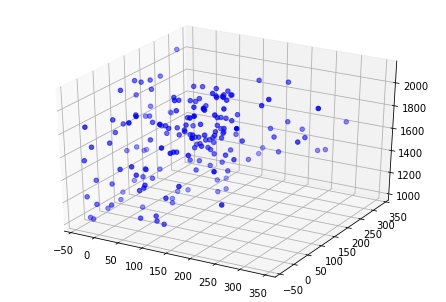

[2, 3, 8]


In [272]:
gear = 6
outputStd = MinMaxScaler(pd.DataFrame.from_records(outputs[gear])).values
nbFeatures = len(featuresMatrix[0])
maxDist = 0
bestFeatures =[]
for i in range(2,nbFeatures):
    for j in range(i+1,nbFeatures):
        for k in range(j+1,nbFeatures):
            newDist = sumDist(np.transpose(np.array([outputStd[:,i], outputStd[:,j], outputStd[:,k]])))
            if newDist>maxDist:
                bestFeatures = [i,j,k]
                maxDist = newDist

fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(outputs[gear][:,bestFeatures[0]], outputs[gear][:,bestFeatures[1]], outputs[gear][:,bestFeatures[2]], c='b', marker='o')
plt.show()
print(bestFeatures)

# Clusterisation

Feature based

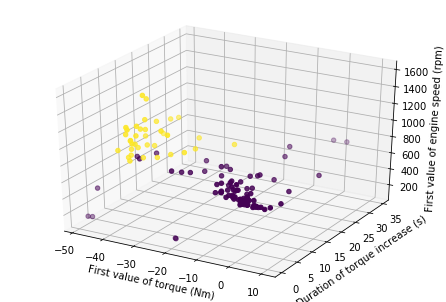

In [122]:
# Automatic approach
gear = 0
output = outputs[gear]
features = featuresA[gear]
kmeans = KMeans(n_clusters=2)
data = np.transpose(np.array([output[:,features[0]+1], output[:,features[1]+1], output[:,features[2]+1]]))
kmeans.fit(data)
lab0 = kmeans.predict(data)

fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(output[:,features[0]+1], output[:,features[1]+1], output[:,features[2]+1], c=lab0, marker='o')
ax.set_xlabel('First value of torque (Nm)')
ax.set_ylabel('Duration of torque increase (s)')
ax.set_zlabel('First value of engine speed (rpm)')
plt.show()

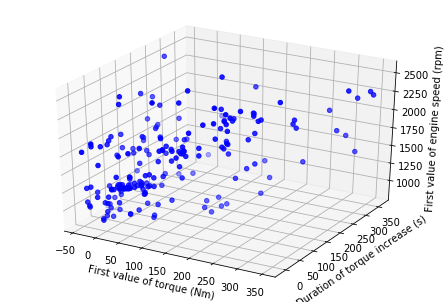

In [15]:
# Manual approach
gear = 4
output = outputs[gear]
features = featuresA[gear]



fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(output[:,features[0]+1], output[:,features[1]+1], output[:,features[2]+1], c='b', marker='o')
ax.set_xlabel('First value of torque (Nm)')
ax.set_ylabel('Duration of torque increase (s)')
ax.set_zlabel('First value of engine speed (rpm)')
plt.show()

In [100]:
def getClusters(featuresMatrix,clusterFunction):
    labels = []
    for i in range(len(featuresMatrix)):
        labels.append(clusterFunction(featuresMatrix[i]))
    return labels

def clusterFunction1(feature):
    x = feature[0]
    y = feature[1]
    z = feature[2]
    if x<40 and y<50 and z<1000:
        return 10
    else:
        if z<1200:
            return 11
        else:
            return 12
        
def clusterFunction2(feature):
    x = feature[0]
    y = feature[1]
    z = feature[2]
    if x<10 and y<150 and z<1200:
        return 20
    else:
        if x < 10:
            return 21
        else:
            return 22
    
    
def clusterFunction3(feature):
    x = feature[0]
    y = feature[1]
    z = feature[2]
    if x<100 and y<85 and z<1800:
        return 30
    else:
        return 31
    
def clusterFunction4(feature):
    x = feature[0]
    y = feature[1]
    z = feature[2]
    if x < 100 and y<200:
        if z<1300:
            return 40
        else:
            return 41
    else:
        return 42
    
def clusterFunction5(feature):
    x = feature[0]
    y = feature[1]
    z = feature[2]
    if x<0 and y<200:
        return 50
    else:
        return 51
        
    
def clusterFunction6(feature):
    x = feature[0]
    y = feature[1]
    z = feature[2]
    if x<10:
        return 60
    else:
        if y<50:
            return 61
        else:
            return 62

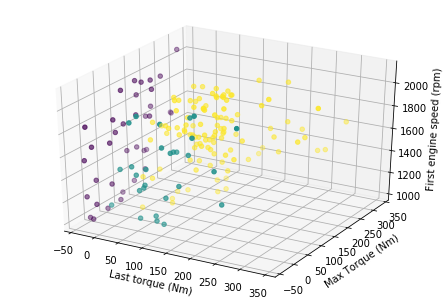

In [101]:
gear = 6
output = outputs[gear]
features = featuresA[gear]
data = np.transpose(np.array([output[:,features[0]+1], output[:,features[1]+1], output[:,features[2]+1]]))
lab6 = getClusters(data,clusterFunction6)

fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(output[:,features[0]+1], output[:,features[1]+1], output[:,features[2]+1], c=lab6, marker='o')
ax.set_xlabel('Last torque (Nm)')
ax.set_ylabel('Max Torque (Nm)')
ax.set_zlabel('First engine speed (rpm)')
plt.show()

In [123]:
labels = []
labels.append(lab0)
labels.append(np.array(lab1))
labels.append(np.array(lab2))
labels.append(np.array(lab3))
labels.append(np.array(lab4))
labels.append(np.array(lab5))
labels.append(np.array(lab6))

featuresA = []
featuresA.append([1,4,6])
featuresA.append([3,5,7])
featuresA.append([1,3,6])
featuresA.append([3,5,6])
featuresA.append([2,3,6])
featuresA.append([1,2,3])
featuresA.append([1,2,7])

In [106]:
labels

[array([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1,
        1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
        0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1,
        1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0,
        0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0,
        0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0,
        0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [208]:
def orderLabels(labels,nbHoops,outputs):
    orderedLabels = [-1]*nbHoops
    for i in range(len(labels)):
        for j in range(len(labels[i])):
            orderedLabels[int(outputs[i][j][1])] = str(labels[i][j])
    return orderedLabels

In [209]:
orderedLabels = orderLabels(labels,len(featuresDf),outputs)

In [258]:
orderedLabels
di = frequencyAssociation(orderedLabels,2)

In [259]:
import collections
di = collections.OrderedDict(sorted(di.items()))

In [271]:
letters = []
for l in orderedLabels:
    if l=='0':
        letters.append('A')
    if l=='1':
        letters.append('B')
    if l=='10':
        letters.append('C')
    if l=='11':
        letters.append('D')
    if l=='12':
        letters.append('E')
    if l=='20':
        letters.append('F')
    if l=='21':
        letters.append('G')
    if l=='22':
        letters.append('H')
    if l=='30':
        letters.append('I')
    if l=='31':
        letters.append('J')
    if l=='40':
        letters.append('K')
    if l=='41':
        letters.append('L')
    if l=='42':
        letters.append('M')
    if l=='50':
        letters.append('N')
    if l=='51':
        letters.append('O')
    if l=='60':
        letters.append('P')
    if l=='61':
        letters.append('Q')
    if l=='62':
        letters.append('R')

In [270]:
len(pd.DataFrame(orderedLabels)[0].unique())

18

In [278]:
probahoops(pd.DataFrame(letters),1,1)[0].sort_values(ascending=False)

K -> K    0.783784
R -> R    0.756757
Q -> P    0.750000
O -> O    0.692308
I -> I    0.608491
P -> R    0.583333
M -> M    0.577465
L -> L    0.534483
D -> E    0.508929
C -> D    0.487500
F -> F    0.480198
N -> O    0.450000
J -> I    0.427632
N -> N    0.416667
E -> G    0.402685
A -> D    0.333333
E -> E    0.315436
J -> J    0.309211
B -> D    0.305556
A -> A    0.300000
G -> G    0.296053
L -> M    0.275862
H -> J    0.265152
C -> C    0.262500
H -> H    0.250000
G -> F    0.243421
F -> H    0.222772
A -> E    0.211111
R -> Q    0.198198
B -> C    0.194444
            ...   
G -> M    0.000000
J -> H    0.000000
R -> H    0.000000
R -> G    0.000000
K -> R    0.000000
M -> B    0.000000
L -> R    0.000000
L -> Q    0.000000
L -> P    0.000000
L -> O    0.000000
R -> E    0.000000
L -> J    0.000000
L -> H    0.000000
L -> E    0.000000
L -> D    0.000000
L -> A    0.000000
K -> Q    0.000000
J -> N    0.000000
K -> P    0.000000
K -> N    0.000000
R -> F    0.000000
K -> H    0.